# Discriminative Classification

### Preliminaries

- Goal 
  - Introduction to discriminative classification models
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 203-206 
    - [T. Minka, Discriminative modes, not discriminative traing](./files/Minka-2005 -Discriminative-models-not-discriminative-training.pdf)

###  Problem: difficult class-conditional data distribitions

Our task will be the same as in the preceding class on (generative) classification. But this time, the class-conditional data distributions look very non-Gaussian, yet the linear discriminative boundary looks easy enough:

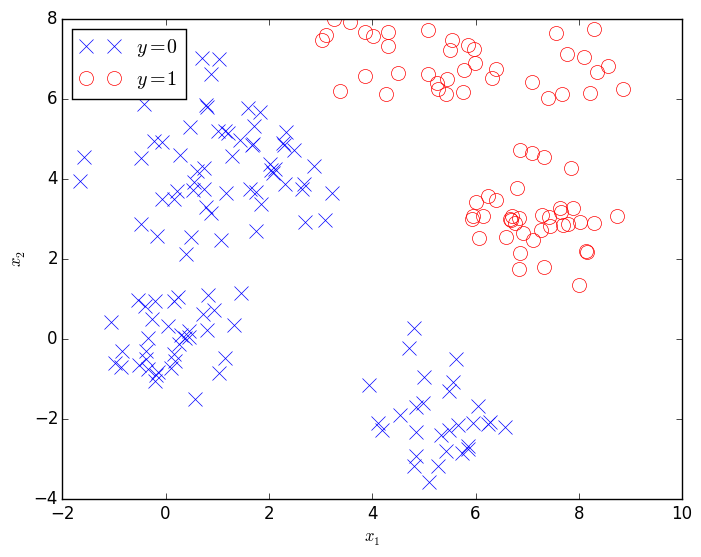

In [1]:
# Generate dataset {(x1,y1),...,(xN,yN)}
# x is a 2-d feature vector [x_1;x_2]
# y ∈ {false,true} is a binary class label
# p(x|y) is multi-modal (mixture of uniform and Gaussian distributions)
using PyPlot
include("scripts/lesson8_helpers.jl")
N = 200
X, y = genDataset(N) # Generate data set, collect in matrix X and vector y
X_c1 = X[:,find(!y)]'; X_c2 = X[:,find(y)]' # Split X based on class label
plot(X_c1[:,1], X_c1[:,2], "bx", markersize=10)
plot(X_c2[:,1], X_c2[:,2], "ro", markersize=10, fillstyle="none")
xlabel(L"x_1"); ylabel(L"x_2"); legend([L"y=0", L"y=1"], 2)
xlim([-2;10]); ylim([-4, 8]);

In this class, we will build a classifier for such cases. 

###  Main Idea of Discriminative Classification 

- Again, a data set is given by  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$ with $x_n \in \mathbb{R}^D$ and $y_n \in \mathcal{C}_k$, with $k=1,\ldots,K$.

-  Sometimes, the precise assumptions of the (multinomial-Gaussian) generative model $$p(x,\mathcal{C}_k|\theta) =  \pi_k \cdot \mathcal{N}(x|\mu_k,\Sigma)$$ clearly do not match the data distribution.

##### Idea

- Model the posterior $$p(\mathcal{C}_k|x)$$  _directly_, without any assumptions on the class densities.

- Of course, this implies also that we build direct models for the **discrimination boundaries** 
  $$\log \frac{p(\mathcal{C}_k|x)}{p(\mathcal{C}_j|x)} =0$$





### Model Specification 

- <span style="color:blue">[Q.]</span>What model should we use for $p(\mathcal{C}_k|x)$?

-   <span style="color:blue">[A.]</span> Get inspiration from the generative approach: choose the familiar softmax structure for the posterior class probability
$$
p(\mathcal{C}_k|x,\theta_k) = \frac{e^{\theta_k^T x}}{\sum_j e^{\theta_j^T x}}
$$
but **do not impose a Gaussian structure on the classes**.

- $\Rightarrow$ There are **two key differences** between the discriminative and generative approach: 
  1. In the discriminative appraoch, the parameters $\theta_k$ are **not** structured into $\{\mu_k,\Sigma,\pi_k \}$. This provides discriminative approach with more flexibility.
  2. ML learning for the discriminative approach by optimization of _conditional_ likelihood $\prod_n p(y_n|x_n,\theta)$ rather than _joint_ likelihood $\prod_n p(y_n,x_n|\theta)$.




 ###  ML Estimation for Discriminative Classification
 
- As we will see, ML estimation for discriminative classification is more complex than for the linear Gaussian generative approach.

-  Work out the conditional log-likelihood 
     $$
    \mathrm{L}(\theta) = \log \prod_n \prod_k {\underbrace{p(\mathcal{C}_k|x_n,\theta)}_{p_{nk}}}^{y_{nk}} = \sum_{n,k} y_{nk} \log p_{nk}
     $$
     
- Use the fact that the softmax $\phi_k=e^{z_k}/{\sum_j e^{z_j}}$ has analytical derivative:

$$ \begin{align*}
 \frac{\partial \phi_k}{\partial z_j} &= \frac{(\sum_j e^{z_j})e^{z_k}\delta_{kj}-e^{z_j}e^{z_k}}{(\sum_j e^{z_j})^2} = \frac{e^{z_k}}{\sum_j e^{z_j}}\delta_{kj} - \frac{e^{z_j}}{\sum_j e^{z_j}} \frac{e^{z_k}}{\sum_j e^{z_j}}\\
     &= \phi_k \cdot(\delta_{kj}-\phi_j)
 \end{align*}$$

<!---
%    -  Again we try to minimize the cross-entropy ($\sum_{nk} y_{nk} \log \frac{y_{nk}}{p_{nk}}$) between the data `targets' $t_{nk}$ and the model outputs $p_{nk}$.
--->

 -  Take the derivative of $\mathrm{L}(\theta)$ (or: how to spend a hour ...)
$$\begin{align*} 
\nabla_{\theta_j} \mathrm{L}(\theta) &= \sum_{n,k} \frac{\partial \mathrm{L}_{nk}}{\partial p_{nk}} \cdot\frac{\partial p_{nk}}{\partial z_{nj}}\cdot\frac{\partial z_{nj}}{\partial \theta_j} \\
  &= \sum_{n,k} \frac{y_{nk}}{p_{nk}} \cdot p_{nk} (\delta_{kj}-p_{nj}) \cdot x_n \\
  &= \sum_n \Big( y_{nj} (1-p_{nj}) -\sum_{k\neq j} y_{nk} p_{nj} \Big) \cdot x_n \\
  &= \sum_n \left( y_{nj} - p_{nj} \right)\cdot x_n \\
  &= \sum_n \Big( \underbrace{y_{nj}}_{\text{target}} - \underbrace{\frac{e^{\theta_j^T x_n}}{\sum_{j^\prime} e^{\theta_{j^\prime}^T x_n}}}_{\text{prediction}} \Big)\cdot x_n 
\end{align*}$$

  
- The derivation for the derivative was painful, but the result is extremely simple. Compare the gradients for linear and logistic regression:
$$\begin{align*}
\nabla_\theta \mathrm{L}(\theta) &=  \sum_n \left(y_n - \theta^T x_n \right)  x_n  \tag{linear} \\
\nabla_\theta \mathrm{L}(\theta) &=  \sum_n \left(y_n - \frac{1}{1+e^{-\theta^Tx_n}} \right) x_n
 \tag{logistic}
\end{align*}$$
In both cases
$$
\nabla_\theta \mathrm{L} =  \sum_n \left( \text{target}_n - \text{prediction}_n \right) \cdot \text{input}_n 
$$

- The parameter vector $\theta$ for logistic regression can be estimated through iterative gradient-based adaptation. E.g. (with iteration index $i$),

$$
\hat{\theta}^{(i+1)} = \hat{\theta}^{(i)} + \eta \cdot \nabla_\theta \mathrm{L}(\theta) 
$$
    




### Application - Classify a new input

-  Discriminative model-based prediction for a new input $x_\bullet$ is easy, namely substitute the ML estimate in the model to get

$$
p(\mathcal{C}_k |\, x_\bullet,\hat\theta) = \frac{ \mathrm{exp}\left( \hat \theta_k^T x_\bullet \right) }{ \sum_j \mathrm{exp}\left(\hat \theta_j^T x_\bullet \right)} 
  \propto \mathrm{exp}\left(\hat \theta_k^T x_\bullet\right) 
$$

-  The contours of equal probability (**discriminant boundaries**) are lines (hyperplanes) in feature space given by
$$
\log \frac{{p(\mathcal{C}_k|x,\hat \theta )}}{{p(\mathcal{C}_j|x,\hat \theta )}} = \left( \hat{\theta}_{k} - \hat{\theta}_j\right) ^T x = 0
$$


<span style="color:red">Marco: Can you finish the simulation here: 
(1) run discriminative classification and plot the discrimination boudaries. (2)computer posterior prob for a new data point. (3) Then run generartive classification on the same data set and show the difference,eg overlay discrimination boundaries in teh same plot .</span>

### Recap Classification
<table>
<tr> <td></td><td>**Generative**</td> <td>**Discriminative**</td> </tr> 

<tr> <td>1</td><td>Like **density estimation**, model joint prob.
$$p(\mathcal{C}_k) p(x|\mathcal{C}_k) = \pi_k \mathcal{N}(\mu_k,\Sigma)$$</td> <td>Like (linear) **regression**, model conditional
$$p(\mathcal{C}_k|x,\theta)$$</td> </tr>

<tr> <td>2</td><td>Leads to **softmax** posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
with **structured** $\theta$</td> <td> **Choose** also softmax posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
but now with 'free' $\theta$</td> </tr>

<tr> <td>3</td><td>For Gaussian $p(x|\mathcal{C}_k)$ and multinomial priors,
$$\hat \theta_k  = \left[ {\begin{array}{c}
   { - \frac{1}{2} \mu_k^T \sigma^{-1} \mu_k  + \log \pi_k}  \\
   {\sigma^{-1} \mu_k }  \\
\end{array}} \right]$$
in one shot.</td> <td>Find $\hat\theta$ through gradient-based adaptation
$$\nabla_{\theta} \log p(D|\theta) = \sum_n \left(t_n - \frac{1}{1+e^{-\theta^Tx_n}}\right)x_n$$</td> </tr>

</table>

-----
_The cell below loads the style file_


In [2]:
open("../../styles/aipstyle.html") do f
    display("text/html", readall(f))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->